<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

In [ ]:
#hide
#For running in JupyterHub:
import os
if os.path.basename(os.getcwd())!='nbs':
    homedir = os.path.expanduser("~")
    lib_path = os.path.join(homedir,'images','codesDIR/vertex_simulation/nbs')
    os.chdir(lib_path)

Modules:
- `primitives`: implements vertices (w/ distance), edges, cells (w/ perimeter and area), and monolayer (with energy, boundary constraints, and other parameters)
- `simulation`: tools for  simulating cellular vertex dynamics. Iterative algorithm implementations, cell monolayer generators (vertices). (anything else to add?!)

In [ ]:
#hide



from vertex_simulation.primitives import *
from vertex_simulation.simulation import *
import torch, numpy as np, matplotlib.pylab as plt
from mpl_toolkits.mplot3d import axes3d
# after you modify this notebook use "nbdev_build_docs" to build the docs (and readme.md)
# and nbdev_clean_nbs to remove notebook metadata before pushing it

## Install

`pip install vertex_simulation` (not yet implemented, for now just clone from git repo)

## Using autograd with Vertex, Graph and Monolayer

In examples below, it is assumed that you've imported `primitives` module. You can do so with 
```
from vertex_simulation.primitives import *
```

### Initializing and working with `Vertex` and `Graph` objects

`Graph` objects implement graphs and stores its vertices as a `Vertex` object, and its edges as a `torch.tensor`. Both `Vertex` and `Graph` provide interface methods for working with torch's autograd, and methods for calculating edge lengths (or vertex to vertex distance in the case `Vertex`).

To illustrate how to use autograd, let's use `Vertex` object. We can define `Vertex` object with its location, or set and modify it later. Location is stored as `Vertex.x` property, a `torch.tensor`. `Vertex(location)` accepts `torch.tensors`, list of lists that are convertible to tensors (with optional keyword arg-s for `torch.tensor()`), and numpy.ndarrays (uses `torch.from_numpy()`)
- `v.x` (i.e. location for `v=Vertex(location)`) is assumed to be Nx2 array with float dtype (or any 2D array), and sizes are __not__ checked when set using `self.x`.
- Computing gradients, and resetting them to zeros. Example below demonstrates computing $\partial y/\partial v_{i,j}$ for $y = \sum_i\sum_j v_{i,j}^2$ using `torch.autograd`.

In [ ]:
v = Vertex([[3.,-1.],[0.1,0.]],requires_grad=True,dtype=torch.float32)
# do some calculation with v.x
y = torch.sum(v.x**2)
# calculate grad-s
y.backward()
print('dy/dx_i after y.backward():\n',v.grad())
# set grad-s to zeros (useful when you don't want to accumulate grad-s)
v.zero_grad_()
print('dy/dx_i after zeroing grad-s:\n',v.grad())

dy/dx_i after y.backward():
 tensor([[ 6.0000, -2.0000],
        [ 0.2000,  0.0000]])
dy/dx_i after zeroing grad-s:
 tensor([[0., 0.],
        [0., 0.]])


#### Vertex usage example
<a name="ex1">Trapped particle in a 2D fluid</a>

Let's assume linear drag, where force exerted by a spring is proportional to the velocity of the particle (drag force is $F_d=-b\frac{dx(t')}{dt'}$)
$$F_s(t') = -\nabla U = b\frac{dx(t')}{dt'}$$
where $U$ is the potential energy of the spring (e.g. optical trap) $U=k\cdot |r|^2$, where $r$ is the vector from equilibrium point, $o$, pointing to the current location of the particle, $x$. After re-defining time ($t'$) as a relative "scaled" time $t=\frac{t'}{b}$ and taking gradient of potential energy w.r.t. $x$, we can re-write the equation of motion (also let's set $o$ as origin $[0,0]$, then $r=x$)
$$\frac{dx(t)}{dt}=-2k(x-o)= -2kx$$
Let's numerically solve this equation ( _refer to the code cell below_ ). If the scale of the step size is chosen well (e.g. in the code below for large `k` use smaller `Dt`), solution $x(t)$ should converge to the equilibrium point $o$.

One way to model this system is to use two vertices, one for constant equilibrium point $o$, and a second vertex for particle position $x(t)$. To track potential energy gradient w.r.t. $x(t)$ we'll set `requires_grad=True` for the moving vertex, `v1` in the code below (this flag enables `torch`'s autograd to backpropagate the gradients).

In [ ]:
o  = Vertex(torch.tensor([[0,0]],dtype=torch.float64)) # equilibrium point (where U(x) is minimum)
v1 = Vertex(torch.tensor([[-3,3]],requires_grad=True,dtype=torch.float64)) # particles location
r = o.dist(v1)
print(f'distance from equilibrium (r):{r.item():.4f}')
print(f'o requires_grad? :{o.requires_grad()}',
      f'\nv1 requires_grad?:{v1.requires_grad()}',
      f'\nr requires_grad? :{r.requires_grad}')
# note that for Vertex self.requires_grad() is a function

distance from equilibrium (r):4.2426
o requires_grad? :False 
v1 requires_grad?:True 
r requires_grad? :True


In order to calculate gradients w.r.t. $x$, we need to set up a function that maps $x$ to some scalar value. In our example, this function is the potential energy function $U(x)$ (`energy(r)` below). Once `energy` function is evalutated, we need to call `backward()` on the returned `torch.tensor` to calculate (analytic) gradient of potential energy function at $x=v1$ (i.e. $\nabla_x U|_{x=v1}$; `dEdx` in code below)

In [ ]:
# Define energy
k = 1.0
energy = lambda r: k*r**2
E = energy(r)
print(f'Energy=kr^2 :{E.item():.4f}')
# compute gradients
E.backward()
dEdx = v1.grad().data
dxdt = -dEdx
print(f't=0: dE/dx={dEdx.tolist()} --> dx/dt=-dE/dx={dxdt.tolist()}')

Energy=kr^2 :18.0000
t=0: dE/dx=[[-6.0, 6.0]] --> dx/dt=-dE/dx=[[6.0, -6.0]]


An important point to keep in mind when using iterative methods (e.g. gradient descent) shown in the code below, is to remember to reset gradients accumulator to zeros. For `Vertex` objects its done with `Vertex.zero_grad_()`, if the vertex has `requires_grad=True` flag, calling this method sets all gradients of a given vertex to zeros. Otherwise it does nothing, e.g. gradients w.r.t. $o$ are kept as `None`, and they are not calculated.

In [ ]:
# Numerical integration
Dt = .16 # time step size
positions = [v1.x.tolist()]
t = [0]
Energies = []
print('Integration (Euler\'s method):')
for n in range(25):
    v1.zero_grad_()
    E = energy(o.dist(v1))  # elastic energy, o.dist(v1) is distance from vertex "o"
    Energies.append(E.item())
    E.backward()   # compute gradients
    dxdt = -v1.grad().data# dx/dt=-dE/dx
    if n%5==0:
        print(f't={Dt*n:.2f}:r={o.dist(v1).item():4.3f}; E={E.item():.2g}; dx/dt={dxdt}')
    # Update vertex position
    with torch.no_grad():
        v1.x += dxdt*Dt
    positions.append(v1.x.tolist()); t.append(t[-1]+Dt)
Energies.append( energy(o.dist(v1)).item() )

Integration (Euler's method):
t=0.00:r=4.243; E=18; dx/dt=tensor([[ 6., -6.]], dtype=torch.float64)
t=0.80:r=0.617; E=0.38; dx/dt=tensor([[ 0.8724, -0.8724]], dtype=torch.float64)
t=1.60:r=0.090; E=0.008; dx/dt=tensor([[ 0.1268, -0.1268]], dtype=torch.float64)
t=2.40:r=0.013; E=0.00017; dx/dt=tensor([[ 0.0184, -0.0184]], dtype=torch.float64)
t=3.20:r=0.002; E=3.6e-06; dx/dt=tensor([[ 0.0027, -0.0027]], dtype=torch.float64)


Results of the numerical integration above-- the evolution of the system in relative time, are shown below. Keep in mind that, in this simulation time is scaled by drag coefficient $b$, and for more accurate dynamics we need to use smaller `Dt` (or more accurate method for numerical integration).

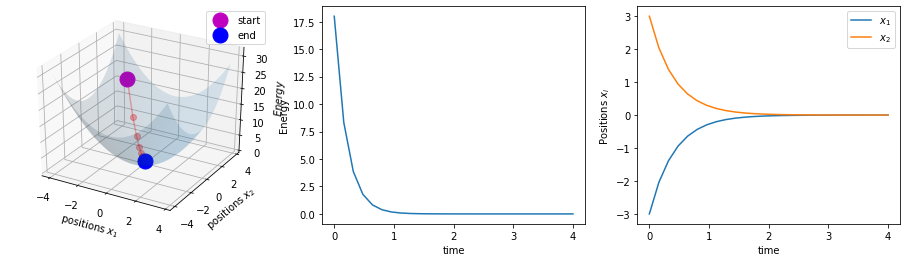

In [ ]:
# Display the results
positions = np.array(positions).squeeze() # convert to a np array
fig = plt.figure(figsize=plt.figaspect(0.25))

# Energy as a function of position and particle trajectory
ax = fig.add_subplot(1, 3, 1, projection='3d')
# Plot the Energy surface
Xmesh,Ymesh = np.meshgrid(np.arange(-4,4,.25),np.arange(-4,4,.25))
Zmesh = k*((Xmesh-o.x[0,0].numpy())**2+(Ymesh-o.x[0,1].numpy())**2) # potential energy surface
ax.plot_surface(Xmesh,Ymesh, Zmesh, alpha=0.15)
# Plot trajectory of the vertex E,x1,x2
ax.plot(positions[:,0],positions[:,1],Energies,'ro-',alpha=.3)
ax.plot(positions[:1,0],positions[:1,1],Energies[:1],'mo',ms=15,label='start')
ax.plot(positions[-1:,0],positions[-1:,1],Energies[-1:],'bo',ms=15,label='end')
ax.set_xlabel('positions $x_1$'); ax.set_ylabel('positions $x_2$'); ax.set_zlabel('$Energy$');
plt.legend();

# Energy as function of time
ax = fig.add_subplot(1, 3, 2);
ax.plot(t,Energies);
ax.set_xlabel('time'); ax.set_ylabel('Energy')

# Vertex position (components) as a function of time
ax = fig.add_subplot(1, 3, 3)
ax.plot(t,positions);
plt.legend(['$x_1$','$x_2$']);
ax.set_ylabel('Positions $x_i$'); ax.set_xlabel('time');

plt.show()

#### `Graph` usage example
<a name="ex2">Attracting particles in a 2D fluid</a>

Now, let's evolve in time a system decribed by a potential
$$U=k\sum_{\forall ij|j\neq i}|x_i-x_j|^2=k\sum_{\forall ij|j\neq i}l^2_{ij}$$
where every vertex $i$ is connected to all the other vertices $j$ with edges $ij$, and $x_i$ is the position of vertex $i$ on a 2D plane (vector). Force balance equation for this system, same as in [Example 1](#ex1) is 
$$b\frac{dx(t')}{dt'}=-\nabla U$$
$\nabla U$ is a function of distances between all possible pairs of vertices (edge lengths $l_{ij}$, scalars). The equation of motion for every vertex is (with $t=t'/b$)
$$\frac{dx_i}{dt}=-k\sum_{\forall ij|j\neq i}2(x_i-x_j)= 2k\sum_{\forall ij|j\neq i}(x_j-x_i)$$
This system can be described by a complete graph, `G` in the code below. In order to demonstrate how to work with this type of systems, let's create a complete graph with $N_v$ vertices.

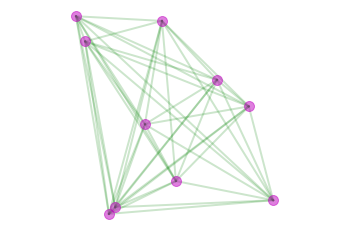

In [ ]:
np.random.seed(42) # let's seed RNG for sanity and reproducibility
Nv = 10 # number of vertices
Xv = np.random.uniform(0,1,(Nv,2)) # initial vertex potions sampled from uniform distribution [0,1)
edges = [[i,j] for i in range(Nv) for j in range(i+1,Nv) if i!=j] # list of edges for complete graph
plot_graph(Xv,edges) # plot vertices and edges

Now, let's solve $x(t)$ with Euler's method. Note that in the code below, `Dt` must be smaller for large $N_v$ (e.g. about $0.01$ or less for $N_v=10$, and about $0.001$ for $N_v=100$). Try changing the parameters (one at a time) and observe what happens.

Number of vertices: 10 
Number of edges: 45 
Requires grad?: True
Integration (Euler's method):
t=0.001: E=2e+01; aver |dx/dt|= 8
t=0.032: E=5; aver |dx/dt|= 4
t=0.063: E=1; aver |dx/dt|= 2
t=0.095: E=0.4; aver |dx/dt|= 1
t=0.126: E=0.1; aver |dx/dt|= 0.6
t=0.157: E=0.03; aver |dx/dt|= 0.3
t=0.188: E=0.008; aver |dx/dt|= 0.2
t=0.220: E=0.002; aver |dx/dt|= 0.09


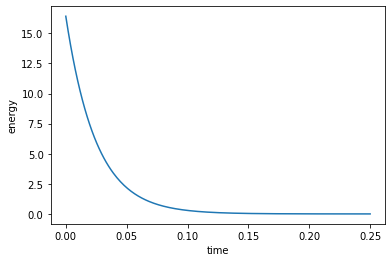

In [ ]:
# initialize a graph
G = Graph(vertices=Vertex(torch.from_numpy(Xv).clone(),requires_grad=True, dtype=torch.float64), edges=torch.tensor(edges) )
G.vertices.requires_grad_(True) # turn on `Vertex` gradients; check its status with G.vertices.requires_grad()
print('Number of vertices:',G.vertices.x.size(0),'\nNumber of edges:', G.edges.size(0),
      '\nRequires grad?:',G.vertices.requires_grad())

# Define energy function
k=1.0
energy = lambda l: k*torch.sum(l**2) # E = k sum(l_ij ^2)
# Numerical integration
Dt = 2**-10 # time step size
positions = [G.vertices.x.clone()]
t = [0]
Energies = []
print('Integration (Euler\'s method):')
for n in range(256):
    G.set_zero_grad_() # reset grad accumulator
    E = energy(G.length())  # total potential energy of the system
    Energies.append(E.item()) # E(t-1)
    E.backward() # compute gradients
    dxdt = -G.get_vertex_grad() # dx/dt=-dE/dx
    # Update vertex position
    with torch.no_grad():
        G.vertices.x += dxdt*Dt
    positions.append(G.vertices.x.clone())
    t.append(t[-1]+Dt)
    if n%32==0:
        mean_grad = torch.norm(dxdt,dim=1).mean().item()
        print(f't={t[-1]:2.3f}: E={E.item():1.1g}; aver |dx/dt|= {mean_grad:1.1g}')
Energies.append( energy(G.length()).item() )
plt.plot(t,Energies);plt.xlabel('time');plt.ylabel('energy');

Results for numerical integration above as a movie of the graph $G$:

In [ ]:
#hide
from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
# hide
from matplotlib import animation, rc
from IPython.display import HTML

# set up figure, axis, and artists
fig, ax = plt.subplots()
xy_min = min(0.0,positions[0].min().item())
xy_max = max(1.0,positions[0].max().item())
ax.axis('square')
ax.axis([xy_min,xy_max,xy_min,xy_max]);ax.axis(False)
edge_lines = []
for ij in G.edges:
    edge_line, = ax.plot([], [],'g-', lw=2,alpha=.2)
    edge_lines.append(edge_line)
node_dots, = ax.plot([], [], 'mo',ms=10,alpha=.5)

# use matplotlib's animation.FuncAnimation
def init():
    ax.set_title(f"{t[0]:4.3f}")
    for edge_line in edge_lines:
        edge_line.set_data([], [])
    node_dots.set_data([], [])
    return (*edge_lines,node_dots)

def animate(i):
    ax.set_title(f"t={t[i]:4.3f}")
    xy = positions[i].detach().numpy()
    for k,edge_line in enumerate(edge_lines):
        ij = G.edges[k,:].numpy()
        edge_line.set_data([xy[ij[0],0],xy[ij[1],0]], [xy[ij[0],1],xy[ij[1],1]])
    node_dots.set_data(xy[:,0], xy[:,1])
    return (*edge_lines,node_dots)

f_anim = animation.FuncAnimation(fig, animate, init_func=init, interval=200,
                                 frames = range(0,len(positions),max(1,round(len(positions)/64))))
plt.close()

In [ ]:
HTML(f_anim.to_jshtml()) # using HTML from IPython.display and matplotlib's animation module

### `Monolayer` objects

`Monolayer` object stores vertices, edges, and cells and implements methods for working wiht torch's autograd. In order to demonstrate how to use `Monolayer` objects, we start with generating cells. Here we will use Voronoi tessellation.

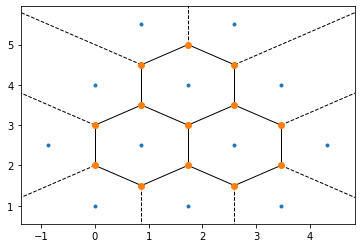

In [ ]:
from scipy.spatial import Voronoi,voronoi_plot_2d

v_seeds=np.array([[np.sqrt(3)/2,5.5], [1.5*np.sqrt(3),5.5], [0.,4.],
                  [np.sqrt(3),4.],[2*np.sqrt(3),4.],[-np.sqrt(3)/2,2.5],
                  [np.sqrt(3)/2,2.5],[1.5*np.sqrt(3),2.5],[2.5*np.sqrt(3),2.5],
                  [0.,1.],[2*np.sqrt(3),1.], [np.sqrt(3),1.]])

vrn = Voronoi(v_seeds)
voronoi_plot_2d(vrn)
plt.show()

After obtaining the Voronoi tesselation, use `VoronoiRegions2Edges` to convert regions into a `Monolayer` (and `Graph`) compatible edges and cells representations:

In [ ]:
edge_list,cells = VoronoiRegions2Edges(vrn.regions) # convert regions to edges and cells
print(cells)

{0: [1, 2, 3, 4, 5, 6], 1: [-2, 7, 8, 9, 10, 11], 2: [1, 7, 12, 13, 14, 15]}


`cells` is the `dict` of edge indices. Negative edge indices indicate reversed vertex order:

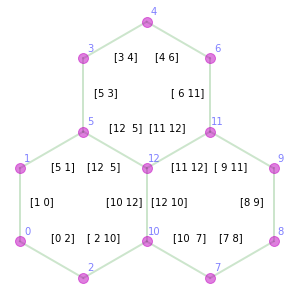

In [ ]:
verts = Vertex(vrn.vertices)
edges = torch.tensor(edge_list)

plt.figure(figsize=[5,5])
plot_graph(verts.x,edges)

# vertex indices
for k,v in enumerate(vrn.vertices):
    plt.text(v[0]+.1,v[1]+.1,f"{k}",c='b',ha='center',alpha=.5)

# cell edges
for c in cells:
    cell_edges = edges[np.abs(cells[c])-1,:] # edge indices (without direction)
    if np.any(np.sign(cells[c])<0):
        # reverse vertex order for negative edges
        tmp = cell_edges[np.sign(cells[c])<0,:].clone()
        cell_edges[np.sign(cells[c])<0,0]=tmp[:,1]
        cell_edges[np.sign(cells[c])<0,1]=tmp[:,0]
    cell_xy = torch.mean(verts.x[cell_edges[:,0],:],0)
    for e in cell_edges:
        e_xy = torch.mean(verts.x[e,:],0)*.65+cell_xy*.35
        plt.text(e_xy[0],e_xy[1],f"{e.numpy()}",ha='center')
plt.show()

#### `Monolayer` dynamics example

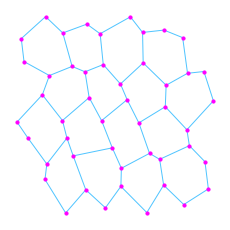

In [ ]:
import networkx as nx
import matplotlib.animation as animation

np.random.seed(42)# let's seed RNG for sanity and reproducibility

v_x,regions =unit_hexagons(4,4) # 4x4 hexagons
# convert Voronoi regions to cells and edges
edge_list,cells = VoronoiRegions2Edges(regions)
# perturb vertices
v_x += np.random.randn(v_x.shape[0], v_x.shape[1])*.2
# define cell monolayer
cell_graph = Monolayer(vertices=Vertex(v_x.copy()), edges=torch.tensor(edge_list), cells=cells)

Gnx,pos=graph2networkx_with_pos(cell_graph)
fig = plt.figure(figsize=[3,3])
nx.draw(Gnx,pos,node_size=10,node_color='#FF00FF',edge_color='#51C5FF')

### Passive forces case

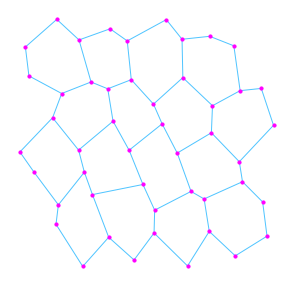

Integration (Euler's method):
t=5.250: E=5.049; aver |dx/dt|= 0.01
t=7.875: E=5.037; aver |dx/dt|= 0.0063
t=13.250: E=5.029; aver |dx/dt|= 0.0033
t=15.875: E=5.027; aver |dx/dt|= 0.0026
t=21.250: E=5.025; aver |dx/dt|= 0.0017
t=23.875: E=5.025; aver |dx/dt|= 0.0014
t=29.250: E=5.024; aver |dx/dt|= 0.0011
t=31.875: E=5.024; aver |dx/dt|= 0.001


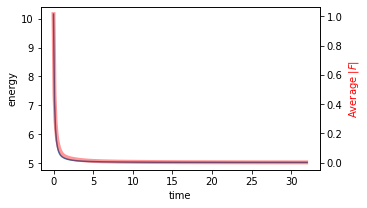

Perimeters:tensor([5.5611, 5.5615, 5.5612, 5.5620, 5.5613, 5.5613, 5.5606, 5.5601, 5.5599,
        5.5599, 5.5608, 5.5609, 5.5620, 5.5610, 5.5612, 5.5586],
       dtype=torch.float64)
Areas:tensor([2.2316, 2.2317, 2.2312, 2.2307, 2.2312, 2.2313, 2.2309, 2.2306, 2.2308,
        2.2307, 2.2311, 2.2314, 2.2314, 2.2314, 2.2316, 2.2297],
       dtype=torch.float64)


In [ ]:
# let's seed RNG for sanity and reproducibility
np.random.seed(42)

# define cell monolayer
v_x,regions =unit_hexagons(4,4) # 4x4 hexagons
# convert Voronoi regions to cells and edges
edge_list,cells = VoronoiRegions2Edges(regions)
# perturb vertices
v_x += np.random.randn(v_x.shape[0], v_x.shape[1])*.2

cell_graph = Monolayer(vertices=Vertex(v_x.copy()), edges=torch.tensor(edge_list), cells=cells)

Gnx,pos=graph2networkx_with_pos(cell_graph)

fig = plt.figure(figsize=[5,5])
fig.clf()
ax = fig.subplots()
ax.axis(False);
nx.draw(Gnx,pos,node_size=10,ax=ax,node_color='#FF00FF',edge_color='#51C5FF')
plt.show()
plt.close()

# Define energy function
energy = lambda p,a: torch.sum(.01*(p)**2)+torch.sum((a-2.3)**2) #
# Numerical integration
Dt = 2**-3 # time step size
t = [0]
Energies = []
Forces = []
verts_t =[]
verts_frames=[]
print('Integration (Euler\'s method):')
t_total = 2**8
cell_graph.vertices.requires_grad_(True)
for n in range(t_total):
    cell_graph.set_zero_grad_() # reset grad accumulator
    E = energy(cell_graph.perimeter(),cell_graph.area())  # total potential energy of the system
    Energies.append(E.item()) # E(t-1)
    E.backward() # compute gradients
    dxdt = -cell_graph.get_vertex_grad() # dx/dt=-dE/dx
    # Update vertex position
    with torch.no_grad():
        cell_graph.vertices.x += dxdt*Dt
        Forces.append(torch.norm(dxdt,dim=1).mean().item())
    if (n+1)%32==0 or n==0:
        verts_t.append(cell_graph.vertices.x.detach().clone())
        verts_frames.append(t[-1])
    if round((n+1)%(t_total/12))==0:
        #plt.figure(figsize=figsize)
        #plot_graph_as_quiver(init_state,quiver_kwargs=quiver_kwargs)
        #plot_graph_as_quiver(cell_graph)
        #plt.axis(axs_lims)
        #plt.show()
        mean_grad = torch.norm(dxdt,dim=1).mean().item()
        print(f't={t[-1]:2.3f}: E={E.item():5.4g}; aver |dx/dt|= {mean_grad:3.2g}')
    t.append(t[-1]+Dt)

Energies.append( energy(cell_graph.perimeter(),cell_graph.area()).item() )
plt.figure(figsize=[5,3])
plt.plot(t,Energies);plt.xlabel('time');plt.ylabel('energy');
# add forces (except last frame)
ax2=plt.gca().twinx()
ax2.set_ylabel('Average $|F|$',color='red')
ax2.plot(t[:-1],Forces,'r-',alpha=.4,lw=4)
plt.show()
# Print final Perimeters and Areas
print(f"Perimeters:{cell_graph.perimeter().detach().squeeze()}\nAreas:{cell_graph.area().detach()}")

In [ ]:
def draw(i):
    pos = dict(zip(range(verts_t[i].shape[0]),verts_t[i].numpy()))
    ax.cla()
    ax.axis('off')
    ax.set_title(f'Epoch:{verts_frames[i]:2.3f}')
    nx.draw(Gnx,pos,node_size=10,ax=ax,node_color='#FF00FF',edge_color='#51C5FF')

# Networkx's edge ordering is different
edge_idx = dict(zip([tuple(e) for e in cell_graph.edges.tolist()],range(cell_graph.edges.shape[0])))
edge_idx_order = [edge_idx[e if e in edge_idx else (e[1],e[0])] for e in Gnx.edges ]
def draw_w_tension(i):
    pos = dict(zip(range(verts_t[i].shape[0]),verts_t[i].numpy()))
    ax.cla()
    ax.axis('off')
    ax.set_title(f'Epoch:{verts_frames[i]:2.3f}')
    #node_color=range(24), node_size=800, cmap=plt.cm.Blues
    nx.draw(Gnx,pos,node_size=10,ax=ax,node_color='#FF00FF',
            edge_color=line_tensions[i].numpy()[edge_idx_order],edge_cmap=plt.cm.bwr)

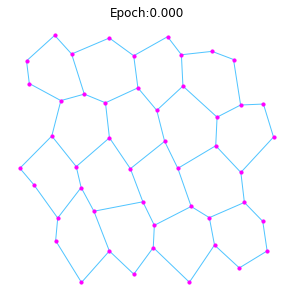

In [ ]:
fig = plt.figure(figsize=[5,5])
fig.clf()
ax = fig.subplots()
ax.axis(False);
draw(0)  # draw the prediction of the first epoch
plt.show()
plt.close()

ani_passive = animation.FuncAnimation(fig, draw, interval=200,
                              frames = range(0,len(verts_t),max(1,round(len(verts_t)/64))))

In [ ]:
print('Passive system (foam)')
HTML(ani_passive.to_jshtml()) # using HTML from IPython.display and matplotlib's animation module

Passive system (foam)


### Active anisotropic forces

#### Edge direction is independent

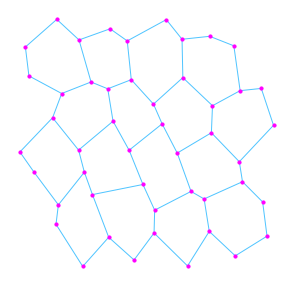

Integration (Euler's method):
t=3.125: E=6.839; aver |dx/dt|= 0.09
t=9.500: E=22.61; aver |dx/dt|= 0.1
t=19.125: E=7.055; aver |dx/dt|= 0.087
t=25.500: E= 22.4; aver |dx/dt|= 0.19


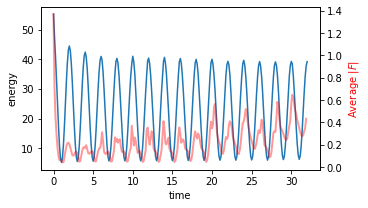

Perimeters:tensor([6.0499, 6.0017, 5.5003, 5.6039, 5.5395, 5.5323, 5.5714, 5.9840, 5.6981,
        5.9557, 5.6414, 6.0062, 5.7545, 5.6840, 6.1331, 6.0374],
       dtype=torch.float64)
Areas:tensor([2.3055, 2.2149, 1.7310, 1.8595, 2.0610, 2.0608, 2.0820, 1.9465, 1.8255,
        2.1463, 2.1237, 2.0063, 1.9984, 1.8990, 2.2595, 2.1053],
       dtype=torch.float64)


In [ ]:
# let's seed RNG for sanity and reproducibility
np.random.seed(42)

# define cell monolayer
v_x,regions =unit_hexagons(4,4) # 4x4 hexagons
# convert Voronoi regions to cells and edges
edge_list,cells = VoronoiRegions2Edges(regions)
# perturb vertices
v_x += np.random.randn(v_x.shape[0], v_x.shape[1])*.2

cell_graph = Monolayer(vertices=Vertex(v_x.copy()), edges=torch.tensor(edge_list), cells=cells)

Gnx,pos=graph2networkx_with_pos(cell_graph)

fig = plt.figure(figsize=[5,5])
fig.clf()
ax = fig.subplots()
ax.axis(False);
nx.draw(Gnx,pos,node_size=10,ax=ax,node_color='#FF00FF',edge_color='#51C5FF')
plt.show()
plt.close()

# Define energy function
omega = torch.tensor([np.pi/2],dtype=cell_graph.vertices.x.dtype)
def monolayer_energy(Perm,Area,Leng,Tau,direction):
    dir_coeff = torch.abs(direction.detach()[:,1])/torch.norm(direction.detach(),dim=1)
    gamma_ij_by_lij = (Leng*dir_coeff.view(-1,1))*torch.cos(omega*Tau)**2
    return (torch.sum(.01*(Perm)**2) + torch.sum((Area-2.3)**2) + torch.sum(gamma_ij_by_lij)), dir_coeff

# Numerical integration
Dt = 2**-3 # time step size
t = [0]
Energies = []
Forces = []
verts_t =[]
verts_frames=[]
line_tensions=[]
print('Integration (Euler\'s method):')
t_total = 2**8
cell_graph.vertices.requires_grad_(True)
for n in range(t_total):
    cell_graph.set_zero_grad_() # reset grad accumulator
    # total potential energy of the system:
    E,edge_tensions = monolayer_energy(cell_graph.perimeter(),cell_graph.area(),
                         cell_graph.length(),t[-1],
                        cell_graph.direction()) 
    Energies.append(E.item()) # E(t-1)
    E.backward() # compute gradients
    dxdt = -cell_graph.get_vertex_grad() # dx/dt=-dE/dx
    # Update vertex position
    with torch.no_grad():
        cell_graph.vertices.x += dxdt*Dt
        Forces.append(torch.norm(dxdt,dim=1).mean().item())
    
    if (n+1)%32==0:
        verts_t.append(cell_graph.vertices.x.detach().clone())
        verts_frames.append(t[-1])
        line_tensions.append(edge_tensions.detach().clone())
    if round((n+1)%(t_total/10))==0:
        mean_grad = torch.norm(dxdt,dim=1).mean().item()
        print(f't={t[-1]:2.3f}: E={E.item():5.4g}; aver |dx/dt|= {mean_grad:3.2g}')
    t.append(t[-1]+Dt) # update last frame time

Energies.append( monolayer_energy( cell_graph.perimeter(), cell_graph.area(),
                                  cell_graph.length(),t[-1],cell_graph.direction())[0].item() )
plt.figure(figsize=[5,3])
plt.plot(t,Energies);plt.xlabel('time');plt.ylabel('energy');
# add forces (except last frame)
ax2=plt.gca().twinx()
ax2.set_ylabel('Average $|F|$',color='red')
ax2.plot(t[:-1],Forces,'r-',alpha=.4,lw=2)
plt.show()
# Print final Perimeters and Areas
print(f"Perimeters:{cell_graph.perimeter().detach().squeeze()}\nAreas:{cell_graph.area().detach()}")

In [ ]:
ani_dir_no_grad = animation.FuncAnimation(fig, draw_w_tension, interval=200,
                              frames = range(0,len(verts_t),max(1,round(len(verts_t)/64))))

In [ ]:
print('Direction is independent of positions (gradient==0)')
HTML(ani_dir_no_grad.to_jshtml()) # using HTML from IPython.display and matplotlib's animation module

Direction is independent of positions (gradient==0)


#### with anisotropy and differentiable edge direction

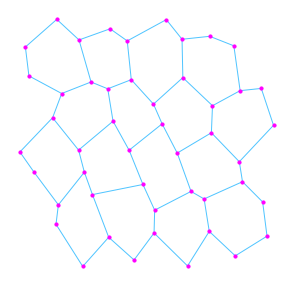

Integration (Euler's method):
t=3.875: E=38.77; aver |dx/dt|= 0.96
t=7.875: E=36.55; aver |dx/dt|= 0.97
t=11.875: E=32.34; aver |dx/dt|= 1.2
t=15.875: E=33.44; aver |dx/dt|= 1.2
t=19.875: E=32.75; aver |dx/dt|= 1.4
t=23.875: E=35.44; aver |dx/dt|= 1.2
t=27.875: E=36.34; aver |dx/dt|= 1.6
t=31.875: E=33.32; aver |dx/dt|= 1.1


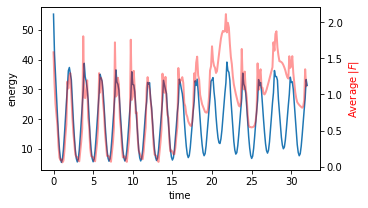

Perimeters:tensor([5.6901, 6.0696, 6.6403, 6.2733, 6.1743, 5.2534, 6.2330, 5.8976, 6.5413,
        6.2207, 5.5036, 6.0924, 6.5333, 6.3229, 5.6527, 6.1501],
       dtype=torch.float64)
Areas:tensor([1.8138, 2.1636, 2.3563, 2.1664, 2.5201, 1.7766, 2.4031, 1.8412, 2.1559,
        1.8074, 1.7786, 2.3087, 1.8523, 2.3815, 1.7450, 1.8092],
       dtype=torch.float64)


In [ ]:
# let's seed RNG for sanity and reproducibility
np.random.seed(42)

# define cell monolayer
v_x,regions =unit_hexagons(4,4) # 4x4 hexagons
# convert Voronoi regions to cells and edges
edge_list,cells = VoronoiRegions2Edges(regions)
# perturb vertices
v_x += np.random.randn(v_x.shape[0], v_x.shape[1])*.2

cell_graph = Monolayer(vertices=Vertex(v_x.copy()), edges=torch.tensor(edge_list), cells=cells)

Gnx,pos=graph2networkx_with_pos(cell_graph)

fig = plt.figure(figsize=[5,5])
fig.clf()
ax = fig.subplots()
ax.axis(False);
nx.draw(Gnx,pos,node_size=10,ax=ax,node_color='#FF00FF',edge_color='#51C5FF')
plt.show()
plt.close()

# Define energy function
omega = torch.tensor([np.pi/2],dtype=cell_graph.vertices.x.dtype)
def monolayer_energy(Perm,Area,Leng,Tau,direction):
    dir_coeff = torch.abs(direction[:,1])/torch.norm(direction,dim=1)
    gamma_ij_by_lij = (Leng*dir_coeff.view(-1,1))*torch.cos(omega*Tau)**2
    return (torch.sum(.01*(Perm)**2) + torch.sum((Area-2.3)**2) + torch.sum(gamma_ij_by_lij)), dir_coeff

# Numerical integration
Dt = 2**-3 # time step size
t = [0]
Energies = []
Forces = []
verts_t =[]
verts_frames=[]
line_tensions=[]
print('Integration (Euler\'s method):')
t_total = 2**8

cell_graph.vertices.requires_grad_(True)
for n in range(t_total):
    cell_graph.set_zero_grad_() # reset grad accumulator
    # total potential energy of the system:
    E,dir_coeff = monolayer_energy(cell_graph.perimeter(),cell_graph.area(),
                         cell_graph.length(),t[-1],
                        cell_graph.direction()) 
    Energies.append(E.item()) # E(t-1)
    E.backward() # compute gradients
    dxdt = -cell_graph.get_vertex_grad() # dx/dt=-dE/dx
    # Update vertex position
    with torch.no_grad():
        cell_graph.vertices.x += dxdt*Dt
        Forces.append(torch.norm(dxdt,dim=1).mean().item())
    
    if (n+1)%32==0:
        verts_t.append(cell_graph.vertices.x.detach().clone())
        verts_frames.append(t[-1])
        line_tensions.append(dir_coeff.detach().clone())
    if round((n+1)%(t_total/8))==0:
        mean_grad = torch.norm(dxdt,dim=1).mean().item()
        print(f't={t[-1]:2.3f}: E={E.item():5.4g}; aver |dx/dt|= {mean_grad:3.2g}')
    t.append(t[-1]+Dt) # update last frame time

Energies.append( monolayer_energy( cell_graph.perimeter(), cell_graph.area(),
                                  cell_graph.length(),t[-1],cell_graph.direction())[0].item() )
plt.figure(figsize=[5,3])
plt.plot(t,Energies);plt.xlabel('time');plt.ylabel('energy');
# add forces (except last frame)
ax2=plt.gca().twinx()
ax2.set_ylabel('Average $|F|$',color='red')
ax2.plot(t[:-1],Forces,'r-',alpha=.4,lw=2)
plt.show()
# Print final Perimeters and Areas
print(f"Perimeters:{cell_graph.perimeter().detach().squeeze()}\nAreas:{cell_graph.area().detach()}")

In [ ]:
ani_dir_grad = animation.FuncAnimation(fig, draw_w_tension, interval=200,
                              frames = range(0,len(verts_t),max(1,round(len(verts_t)/64))))

In [ ]:
print('Direction has gradient w.r.t. positions')
HTML(ani_dir_grad.to_jshtml()) # using HTML from IPython.display and matplotlib's animation module

Direction has gradient w.r.t. positions


#### Anisotropic active forces with lower amplitude

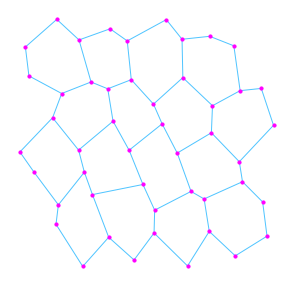

Integration (Euler's method):
t=4.000: E=11.44; aver |dx/dt|= 0.14
t=8.000: E=11.31; aver |dx/dt|= 0.13
t=12.000: E=11.25; aver |dx/dt|= 0.13
t=16.000: E= 11.2; aver |dx/dt|= 0.14
t=20.000: E=11.16; aver |dx/dt|= 0.12
t=24.000: E=11.13; aver |dx/dt|= 0.12
t=28.000: E=11.11; aver |dx/dt|= 0.14
t=32.000: E=11.08; aver |dx/dt|= 0.14


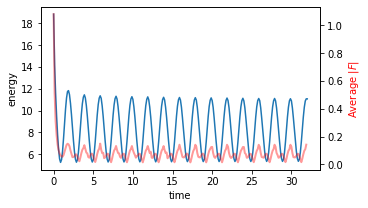

Perimeters:tensor([5.7559, 5.7051, 5.7250, 5.6884, 5.6866, 5.7072, 5.6921, 5.7798, 5.7344,
        5.6844, 5.6780, 5.7795, 5.6978, 5.7184, 5.8035, 5.7215],
       dtype=torch.float64)
Areas:tensor([2.2030, 2.1896, 2.1647, 2.1944, 2.1961, 2.2006, 2.2030, 2.1894, 2.1827,
        2.1942, 2.1999, 2.1935, 2.1477, 2.1983, 2.2127, 2.1796],
       dtype=torch.float64)


In [ ]:
# let's seed RNG for sanity and reproducibility
np.random.seed(42)

# define cell monolayer
v_x,regions =unit_hexagons(4,4) # 4x4 hexagons
# convert Voronoi regions to cells and edges
edge_list,cells = VoronoiRegions2Edges(regions)
# perturb vertices
v_x += np.random.randn(v_x.shape[0], v_x.shape[1])*.2

cell_graph = Monolayer(vertices=Vertex(v_x.copy()), edges=torch.tensor(edge_list), cells=cells)

Gnx,pos=graph2networkx_with_pos(cell_graph)

fig = plt.figure(figsize=[5,5])
fig.clf()
ax = fig.subplots()
ax.axis(False);
nx.draw(Gnx,pos,node_size=10,ax=ax,node_color='#FF00FF',edge_color='#51C5FF')
plt.show()
plt.close()

# Define energy function
omega = torch.tensor([np.pi/2],dtype=cell_graph.vertices.x.dtype)
def monolayer_energy(Perm,Area,Leng,Tau,direction):
    dir_coeff = torch.abs(direction[:,1])/torch.norm(direction,dim=1)/5
    gamma_ij_by_lij = (Leng*dir_coeff.view(-1,1))*torch.cos(omega*Tau)**2
    return (torch.sum(.01*(Perm)**2) + torch.sum((Area-2.3)**2) + torch.sum(gamma_ij_by_lij)), dir_coeff

# Numerical integration
Dt = 2**-3 # time step size
t = [0]
Energies = []
Forces = []
verts_t =[]
verts_frames=[]
line_tensions=[]
print('Integration (Euler\'s method):')
t_total = 2**8

cell_graph.vertices.requires_grad_(True)
for n in range(t_total):
    cell_graph.set_zero_grad_() # reset grad accumulator
    t.append(t[-1]+Dt) # update last frame time
    # total potential energy of the system:
    E,dir_coeffs = monolayer_energy(cell_graph.perimeter(),cell_graph.area(),
                         cell_graph.length(),t[-1],
                        cell_graph.direction()) 
    Energies.append(E.item()) # E(t-1)
    E.backward() # compute gradients
    dxdt = -cell_graph.get_vertex_grad() # dx/dt=-dE/dx
    # Update vertex position
    with torch.no_grad():
        cell_graph.vertices.x += dxdt*Dt
        Forces.append(torch.norm(dxdt,dim=1).mean().item())
    
    if (n+1)%32==0:
        verts_t.append(cell_graph.vertices.x.detach().clone())
        verts_frames.append(t[-1])
        line_tensions.append(dir_coeffs.detach().clone())
    if round((n+1)%(t_total/8))==0:
        mean_grad = torch.norm(dxdt,dim=1).mean().item()
        print(f't={t[-1]:2.3f}: E={E.item():5.4g}; aver |dx/dt|= {mean_grad:3.2g}')
Energies.append( monolayer_energy( cell_graph.perimeter(), cell_graph.area(),
                                  cell_graph.length(),t[-1],cell_graph.direction())[0].item() )
plt.figure(figsize=[5,3])
plt.plot(t,Energies);plt.xlabel('time');plt.ylabel('energy');
# add forces (except last frame)
ax2=plt.gca().twinx()
ax2.set_ylabel('Average $|F|$',color='red')
ax2.plot(t[:-1],Forces,'r-',alpha=.4,lw=2)
plt.show()
# Print final Perimeters and Areas
print(f"Perimeters:{cell_graph.perimeter().detach().squeeze()}\nAreas:{cell_graph.area().detach()}")

In [ ]:
ani_dir_grad_low_amplitude = animation.FuncAnimation(fig, draw_w_tension, interval=200,
                              frames = range(0,len(verts_t),max(1,round(len(verts_t)/64))))

In [ ]:
print('Direction has gradient w.r.t. positions (low line tension: 1/5)')
# using HTML from IPython.display and matplotlib's animation module
HTML(ani_dir_grad_low_amplitude.to_jshtml())

Direction has gradient w.r.t. positions (low line tension: 1/5)


#### Random edges with active tension

In [ ]:
e_ij_coeff = torch.zeros(len(edge_list),1,dtype=cell_graph.vertices.x.dtype)
e_ij_on = np.random.rand(len(edge_list),1)<.2
e_ij_coeff[e_ij_on] = 1.0

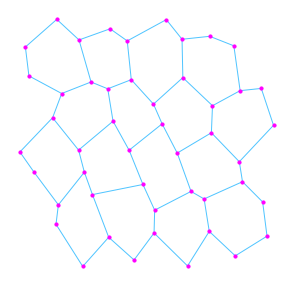

Integration (Euler's method):
t=4.000: E=44.65; aver |dx/dt|= 0.036
t=8.000: E=44.57; aver |dx/dt|= 0.023
t=12.000: E=44.55; aver |dx/dt|= 0.02
t=16.000: E=44.55; aver |dx/dt|= 0.02
t=20.000: E=44.55; aver |dx/dt|= 0.019
t=24.000: E=44.55; aver |dx/dt|= 0.019
t=28.000: E=44.55; aver |dx/dt|= 0.019
t=32.000: E=44.55; aver |dx/dt|= 0.019


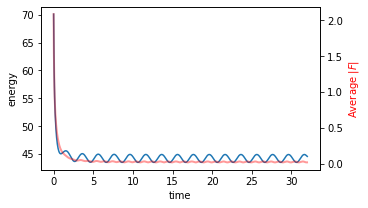

Perimeters:tensor([4.7195, 4.6984, 4.7235, 4.7042, 4.7102, 4.7203, 4.7207, 4.6979, 4.7192,
        4.6319, 4.7224, 4.6920, 4.6888, 4.7378, 4.7123, 4.7216],
       dtype=torch.float64)
Areas:tensor([1.6047, 1.5892, 1.6074, 1.5870, 1.5982, 1.6057, 1.6062, 1.5903, 1.6059,
        1.5388, 1.6089, 1.5799, 1.5738, 1.6174, 1.5997, 1.6087],
       dtype=torch.float64)


In [ ]:
# define cell monolayer
v_x,regions =unit_hexagons(4,4) # 4x4 hexagons
# convert Voronoi regions to cells and edges
edge_list,cells = VoronoiRegions2Edges(regions)
# perturb vertices
np.random.seed(42) # let's seed RNG for sanity and reproducibility
v_x += np.random.randn(v_x.shape[0], v_x.shape[1])*.2

cell_graph = Monolayer(vertices=Vertex(v_x.copy()), edges=torch.tensor(edge_list), cells=cells)

Gnx,pos=graph2networkx_with_pos(cell_graph)

fig = plt.figure(figsize=[5,5])
fig.clf()
ax = fig.subplots()
ax.axis(False);
nx.draw(Gnx,pos,node_size=10,ax=ax,node_color='#FF00FF',edge_color='#51C5FF')
plt.show()
plt.close()

# Define energy function
omega = torch.tensor([np.pi/2],dtype=cell_graph.vertices.x.dtype)
e_ij_coeff = torch.zeros(len(edge_list),1,dtype=cell_graph.vertices.x.dtype)
e_ij_on = np.random.rand(len(edge_list),1)<.2
e_ij_coeff[e_ij_on] = 1.0
e_ij_phase = torch.zeros_like(e_ij_coeff)
e_ij_phase[e_ij_on] = torch.rand((e_ij_on.sum(),),dtype=cell_graph.vertices.x.dtype)
def monolayer_energy(Perm,Area,Leng,Tau,direction):
    gamma_ij_by_lij = (Leng*e_ij_coeff/5)*torch.cos(omega*Tau+e_ij_phase)**2
    return (torch.sum(.1*(Perm)**2) + torch.sum((Area-2.3)**2) + torch.sum(gamma_ij_by_lij)),gamma_ij_by_lij.squeeze()

# Numerical integration
Dt = 2**-5 # time step size
t = [0]
Energies = []
Forces = []
verts_t =[]
verts_frames=[]
line_tensions=[]
print('Integration (Euler\'s method):')
t_total = 2**10

cell_graph.vertices.requires_grad_(True)
for n in range(t_total):
    cell_graph.set_zero_grad_() # reset grad accumulator
    t.append(t[-1]+Dt) # update last frame time
    # total potential energy of the system:
    E,dir_coeffs = monolayer_energy(cell_graph.perimeter(),cell_graph.area(),
                         cell_graph.length(),t[-1],
                        cell_graph.direction()) 
    Energies.append(E.item()) # E(t-1)
    E.backward() # compute gradients
    dxdt = -cell_graph.get_vertex_grad() # dx/dt=-dE/dx
    # Update vertex position
    with torch.no_grad():
        cell_graph.vertices.x += dxdt*Dt
        Forces.append(torch.norm(dxdt,dim=1).mean().item())
    
    if (n+1)%32==0:
        verts_t.append(cell_graph.vertices.x.detach().clone())
        verts_frames.append(t[-1])
        line_tensions.append(dir_coeffs.detach().clone())
    if round((n+1)%(t_total/8))==0:
        mean_grad = torch.norm(dxdt,dim=1).mean().item()
        print(f't={t[-1]:2.3f}: E={E.item():5.4g}; aver |dx/dt|= {mean_grad:3.2g}')
Energies.append( monolayer_energy( cell_graph.perimeter(), cell_graph.area(),
                                  cell_graph.length(),t[-1],cell_graph.direction())[0].item() )
plt.figure(figsize=[5,3])
plt.plot(t,Energies);plt.xlabel('time');plt.ylabel('energy');
# add forces (except last frame)
ax2=plt.gca().twinx()
ax2.set_ylabel('Average $|F|$',color='red')
ax2.plot(t[:-1],Forces,'r-',alpha=.4,lw=2)
plt.show()
# Print final Perimeters and Areas
print(f"Perimeters:{cell_graph.perimeter().detach().squeeze()}\nAreas:{cell_graph.area().detach()}")

In [ ]:
ani_dir_grad_low_mem_low = animation.FuncAnimation(fig, draw_w_tension, interval=200,
                              frames = range(0,len(verts_t),max(1,round(len(verts_t)/128))))

In [ ]:
print('Random edges with active tension')
# using HTML from IPython.display and matplotlib's animation module
HTML(ani_dir_grad_low_mem_low.to_jshtml())

Random edges with active tension


In [ ]:
#hide
# run this as a last cell in your notebook to export this module
from nbdev.export import *
notebook2script()

Converted 00_primitives.ipynb.
Converted 01_simulation.ipynb.
Converted index.ipynb.
Converted vertex_dynamics_models.ipynb.
